# Import dependencies

In [12]:
import pandas as pd       
import numpy as np    
import requests           
import geopandas as gpd    
import shapely
from shapely.geometry import LineString, MultiLineString, Point

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"requests version: {requests.__version__}")
print(f"geopandas version: {gpd.__version__}")
print(f"shapely version: {shapely.__version__}")

pandas version: 1.5.3
numpy version: 1.23.5
requests version: 2.29.0
geopandas version: 0.13.2
shapely version: 2.0.4


# Download roads

In [2]:
# Define the Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Define the bounding box for Africa (approximately)
# Coordinates are (min_latitude, min_longitude, max_latitude, max_longitude)
bbox = (-35.0, -26.0, 38.0, 59.0)

# Function to create a grid of bounding boxes
def create_bbox_grid(min_lat, min_lon, max_lat, max_lon, n):
    lat_points = np.linspace(min_lat, max_lat, n+1)
    lon_points = np.linspace(min_lon, max_lon, n+1)
    bboxes = []
    for i in range(n):
        for j in range(n):
            bboxes.append((lat_points[i], lon_points[j], lat_points[i+1], lon_points[j+1]))
    return bboxes

# Define the number of divisions per side
divisions = 2
bboxes = create_bbox_grid(bbox[0], bbox[1], bbox[2], bbox[3], divisions)


# Function to fetch data for a given bounding box
def fetch_bbox_data(bbox):
    print(bbox)
    overpass_query = f"""
    [out:json][timeout:3600];
    (
      way["highway"~"motorway|trunk|primary|secondary|tertiary"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
      node(w);
    );
    out body;
    >;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    nodes = {element['id']: (element['lon'], element['lat']) for element in data['elements'] if element['type'] == 'node'}
    
    def extract_attributes(element):
        tags = element.get('tags', {})
        node_ids = element.get('nodes', [])
        coords = [nodes[node_id] for node_id in node_ids if node_id in nodes]
        return {
            'osmid': element['id'],
            'highway': tags.get('highway'),
            'surface': tags.get('surface'),
            'width': tags.get('width'),
            'lanes': tags.get('lanes'),
            'oneway': tags.get('oneway', 'no') == 'yes',
            'geometry': LineString(coords) if coords else None
        }

    ways = [extract_attributes(element) for element in data['elements'] if element['type'] == 'way']
    gdf_edges = gpd.GeoDataFrame([way for way in ways if way['geometry'] is not None])
    gdf_edges.set_crs(epsg=4326, inplace=True)
    
    return gdf_edges

# Fetch data for all bounding boxes and combine
gdfs = [fetch_bbox_data(bbox) for bbox in bboxes]
gdf_combined = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Check the size of the resulting GeoDataFrame
print(f"Number of rows: {gdf_combined.shape[0]}")

# Print info about the GeoDataFrame
print(gdf_combined.info())

(-35.0, -26.0, 1.5, 16.5)
(-35.0, 16.5, 1.5, 59.0)
(1.5, -26.0, 38.0, 16.5)
(1.5, 16.5, 38.0, 59.0)
Number of rows: 1755562
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1755562 entries, 0 to 1755561
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   osmid     int64   
 1   highway   object  
 2   surface   object  
 3   width     object  
 4   lanes     object  
 5   oneway    bool    
 6   geometry  geometry
dtypes: bool(1), geometry(1), int64(1), object(4)
memory usage: 82.0+ MB
None


<AxesSubplot:>

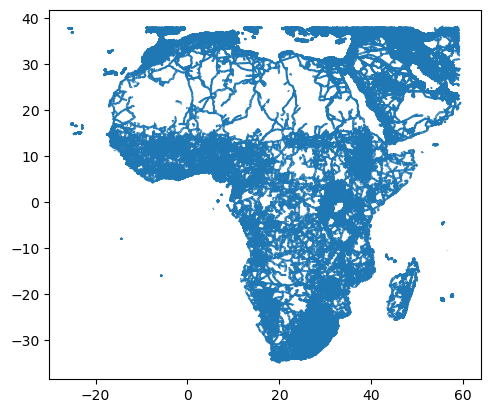

In [3]:
gdf_combined.plot()

# Limit data to country of interest

In [7]:
# read in admin shapefile
# world bank country boundary source: https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries
africa_shp = gpd.read_file('raw data/WB_countries_Admin0_10m/WB_countries_Admin0_10m.SHP')
africa_shp = africa_shp[['FORMAL_EN', 'NAME_EN', 'REGION_WB', 'geometry']]
africa_shp = africa_shp[africa_shp.REGION_WB == 'Sub-Saharan Africa']

In [8]:
assert gdf_combined.crs == africa_shp.crs
# Perform a spatial join to find roads within country boundaries
gdf_combined_sub = gpd.sjoin(gdf_combined, africa_shp[['NAME_EN', 'geometry']], how='inner', op='within')

/Users/tunmiseraji/opt/anaconda3/envs/gee/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [9]:
# missing out on some minor islands
set(africa_shp.NAME_EN.unique()).symmetric_difference(set(gdf_combined_sub.NAME_EN.unique()))

{'British Indian Ocean Territory',
 'French Southern and Antarctic Lands',
 'Heard Island and McDonald Islands'}

<AxesSubplot:>

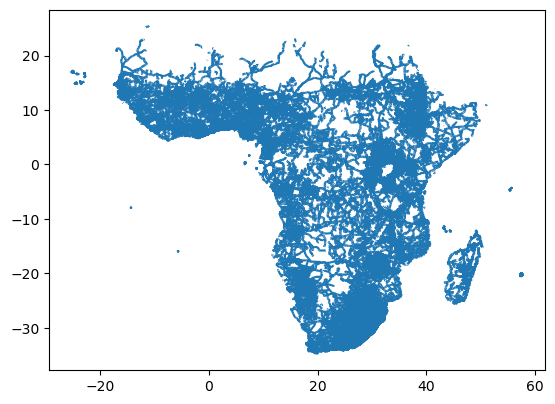

In [10]:
gdf_combined_sub.plot()

# Split roads at the 10km mark to avoid memory errors downstream

In [13]:
def split_line(line, max_length):
    # Function to split a line at a distance from its starting point
    def cut(line, distance):
        if distance <= 0.0 or distance >= line.length:
            return [LineString(line)]
        coords = list(line.coords)
        for i, p in enumerate(coords):
            pd = line.project(Point(p))
            if pd == distance:
                return [
                    LineString(coords[:i+1]),
                    LineString(coords[i:])]
            if pd > distance:
                cp = line.interpolate(distance)
                return [
                    LineString(coords[:i] + [(cp.x, cp.y)]),
                    LineString([(cp.x, cp.y)] + coords[i:])]
    
    # Split the line
    segments = []
    current_line = line
    while current_line.length > max_length:
        segment, current_line = cut(current_line, max_length)
        segments.append(segment)
    segments.append(current_line)
    
    return segments

# Function to handle a MultiLineString by splitting each LineString within it
def process_multilinestring(multilinestring, max_length):
    all_segments = []
    for linestring in multilinestring.geoms:  # Iterating over LineStrings within the MultiLineString
        segments = split_line(linestring, max_length)
        all_segments.extend(segments)  # Adding the segments of this LineString to the list
    return all_segments


# Function to process and split any geometry (LineString or MultiLineString)
def process_geometry(geometry, max_length):
    if isinstance(geometry, LineString):
        return split_line(geometry, max_length)
    elif isinstance(geometry, MultiLineString):
        return process_multilinestring(geometry, max_length)
    else:
        raise TypeError("Geometry must be a LineString or MultiLineString")

# Maximum length of each segment (10 km)
max_length = 10 * 1000  # meters     

# New GeoDataFrames to store split lines
new_dfs = []

countries = gdf_combined_sub.NAME_EN.unique()
for cn in countries:
    gdf_combined_sub_sub = gdf_combined_sub[gdf_combined_sub.NAME_EN == cn]
    utm_crs = gdf_combined_sub_sub.estimate_utm_crs()  # Estimate UTM CRS based on data from country
    gdf_utm = gdf_combined_sub_sub.to_crs(utm_crs)


    # Iterate over each row, process geometries and create new rows
    new_rows = []
    for idx, row in gdf_utm.iterrows():
        # Process geometry (split into segments if necessary)
        segments = process_geometry(row['geometry'], max_length)

#         # Calculate the fraction of the total length for each segment
#         total_length = sum(segment.length for segment in segments)

        # Create new rows with the same attributes but different geometries and fractions
        i = 0
        for segment in segments:
            new_row = row.copy()
            new_row['geometry'] = segment
            new_row['Unique_ID_Fraction'] = i
            new_row['Length'] = segment.length
            i = i + 1 
            new_rows.append(new_row)

    # Create a new GeoDataFrame from the list of new rows
    new_gdf_utm = gpd.GeoDataFrame(new_rows, crs=utm_crs)
    # Reproject back to original CRS
    new_gdf_gov = new_gdf_utm.to_crs(gdf_combined_sub.crs)
    new_dfs.append(new_gdf_gov)
gdf_combined_split = pd.concat(new_dfs)

In [25]:
print('Number of roads b4 split: ', len(gdf_combined_sub))
print('Number of roads after split: ', len(gdf_combined_split), '; Length of roads: ', gdf_combined_split.Length.sum()/1000)

Number of roads b4 split:  490713
Number of roads after split:  554883 ; Length of roads:  1291437.225028038


# Clean up surface descriptions

In [26]:
mapping = {'paved_mzjor': 'paved', 
           's331': '', 
           'sans revêtement': 'unpaved',
           'unhewn_cobblestone': 'cobblestone', 
           'asphalt;unpaved': 'paved', 
           'dirt, tarmac': 'tarmac',
           'asphalt_and_murrum': 'asphalt', 
           'dirt; sand': 'dirt', 
           'salt': 'dirt',
           'sand road, graded occasionally': 'dirt', 
           'wood:lanes': 'wood', 
           'ubpaved': 'unpaved',
           'pebblestone': 'cobblestone', 
           'concrete:lanes': 'concrete', 
           'grass': '', 
           'grass_paver': '', 
           'rock': 'cobblestone',
           'soil': 'dirt', 
           'compacted;ground;unpaved': 'unpaved', 
           'pozzolan': 'soil',
           'JOG': '', 
           '33': '', 
           'concrete:plates': 'concrete',
           'dirt;sand': 'dirt', 
           'karral': '', 
           'metal': '',
           'clay': 'mud', 
           'sett': '',    
           'dirt/sand': 'dirt', 
           'sand': 'dirt',  
           'earth':'dirt',
           'cobblestone': 'paving_stones',
           'fine_gravel': 'gravel',
           'ground': 'dirt',
           'riverbed': 'dirt',# 
           'bitumé':'asphalt',
           'd14_100': '',
           'gravel;asphalt;unpaved': 'paved',
           'Dillapidated': 'dirt',
           'goudron': 'asphalt',
           'a*': '', 
           'asphalt; asphalt; gravel': 'asphalt', 
           'no': '',
           'comp': '', 
           'cement': 'concrete', 
           'concrete_blocks': 'concrete', 
           'paving underway': 'paved', 
           'tartan': '',
           'unoaved': 'unpaved', 
           'shingle': '', 
           'Paved Way': 'paved',
           'RR14': '',
           'Bitumer': 'asphalt', 
           'cc': '', 
           'Bitumee': 'asphalt', 
           'Non Bitume': 'unpaved', 
           '2012': '', 
           'asphaltFresh_details_on_Resident_Evil_8_have_surfaced_via_the_recent_playtest_that_took_place_for_Ambassadors,_describing_the_content_in_the_game?s_prologue_as_well_as_some_other_snippets_of_info_on_enemies_and_other_points_of_interest._New_Resident_Evil': '',
           'paving_stones;asphalt': 'paved', 
           'Non Bitumee': 'unpaved', 
           'bricks': 'concrete',
           'murram': 'dirt', 
           'marum': 'dirt', 
           'bing_image': '',
           'compacted;laterite': 'dirt', 
           'yes': '', 
           'brick': 'concrete',
           'clay;rock': '',
           'sand': 'dirt',
           'chipseal': 'asphalt',
           'asphalt; gravel; asphalt': 'asphalt',
           'compacted;ground': 'dirt',
           'unpaved;paved': '',
           'tarmac': 'asphalt',
           'cobblestone': 'paving_stones',
           'soil': 'dirt',
           'water': '',
           'natural': 'dirt',
          }
gdf_combined_split['surface'] = gdf_combined_split['surface'].replace(mapping)

In [27]:
gdf_combined_split.surface.value_counts(dropna=False)

asphalt          213437
None             151759
unpaved          109862
paved             34609
dirt              19526
gravel            11773
compacted          9935
concrete           2395
paving_stones       915
                    353
wood                178
mud                 112
cobblestone          15
soil                 11
tarmac                3
Name: surface, dtype: int64

In [28]:
# Table 2
# Group by the 'surface' column and calculate the count and sum of 'Length'
gdf_combined_split_no_dup = gdf_combined_split.drop_duplicates()
result = gdf_combined_split_no_dup.groupby('surface').agg(
    no_of_roads=pd.NamedAgg(column='Length', aggfunc='count'),
    sum_length=pd.NamedAgg(column='Length', aggfunc='sum')
)
result['sum_length_km'] = result['sum_length']/1000
result.sort_values(by = 'sum_length_km', ascending=False)

,no_of_roads,sum_length,sum_length_km
surface,,,
unpaved,109435,4.592654e+08,459265.360539
asphalt,213343,2.431590e+08,243158.981539
dirt,19438,8.921856e+07,89218.564647
paved,34581,7.894837e+07,78948.373904
gravel,11708,5.282949e+07,52829.489197
compacted,9891,3.559758e+07,35597.581126
concrete,2395,7.259365e+05,725.936531
,353,5.597132e+05,559.713186
paving_stones,915,4.504836e+05,450.483580


In [29]:
# remove roads without surface types (Nones and empty spaces)
gdf_combined_split_clean = gdf_combined_split.dropna(subset=['surface'])
gdf_combined_split_clean = gdf_combined_split_clean[gdf_combined_split_clean['surface'] != '']  # Drop empty strings

In [30]:
gdf_combined_split_clean.rename(columns={'osmid': 'Unique_ID'}, inplace=True)
gdf_combined_split_clean.rename(columns={'surface': 'Status'}, inplace=True)

# Export

In [ ]:
gdf_combined_split_clean.to_feather('data/roads_sub_split_clean.feather')